In [2]:
import os

# 设置默认编码为UTF-8
os.environ['PYTHONIOENCODING'] = 'utf-8'

# 加载api_key等环境变量
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# 提示词

In [3]:
from utils import show_prompt
from deep_research_from_scratch.my_prompts import final_report_generation_prompt

show_prompt(final_report_generation_prompt, "final_report_generation_prompt")

╭──────────────────────────────────────── final_report_generation_prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│  根据所有进行的研究，为以下总体研究摘要创建一个全面、结构良好的答案：                                           │
│  <Research Brief>                                                                                               │
│  {research_brief}                                                                                               │
│  </Research Brief>                                                                                              │
│                                                                                                                 │
│  关键提示：确保答案使用的语言与人类信息(human messages)相同！                                                   │
│  例如，如果用户的信息是英文，那么请务必用英文撰写您的回复。如果用户的信息是中文，那么请务客服必用中文撰写您的   │
│  整个回复。                                                                                                     │
│  这一点至关重要。只有当答案是用与他们输入信息相同的语言撰写时，用户才能理解。                                   │
│                                                                                                                 │
│  今天的日期是 {date}。                                                                                          │
│                                                                                                                 │
│  以下是您进行的研究的结果：                                                                                     │
│  <Findings>                                                                                                     │
│  {findings}                                                                                                     │
│  </Findings>                                                                                                    │
│                                                                                                                 │
│  请为总体研究摘要创建一个详细的答案，要求如下：                                                                 │
│  1. 组织良好，带有适当的标题（# 用于标题，## 用于章节，### 用于子章节）。                                       │
│  2. 包括研究中的具体事实和见解。                                                                                │
│  3. 使用 [标题](URL) 格式引用相关来源。                                                                         │
│  4.                                                                                                             │
│  提供平衡、透彻的分析。尽可能全面，并包括与总体研究问题相关的所有信息。人们使用您进行深入研究，并期望得到详细   │
│  、全面的答案。                                                                                                 │
│  5. 在末尾包含一个“来源”部分，列出所有引用的链接。                                                              │
│                                                                                                                 │
│  <格式要求>                                                                                                     │
│  {format_constraints}                                                                                           │
│  </格式要求>                                                                                                    │
│                                                                                                                 │
│  请记住：                                                                                                       │
│  - 当用户在格式要求或研究简报中提供了章节列表时，您需要**严格按照章节列表来构建您的报告**。                     │
│  - 请确保优先满足用户在格式要求提到的需求，包括章节列表要求和字数要求等。                                       │
│  - 当用户没有提供章节列表时，您可以按照您认为最佳的任何方式来构建您的报告。                                     │
│  - 确保您的章节内容连贯，并对读者有意义。                                                                       │
│                                                                                                                 │
│  对于报告的每个部分，请执行以下操作：                                                   

# Multi-Agent Research System
- 复用之前的模块

In [4]:
%%writefile deep_research_from_scratch/research_agent_full.py

"""Multi-Agent Research System"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.my_prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ==== Config ====

import os
from langchain.chat_models import init_chat_model
# 模型初始化
api_url = os.getenv('ARK_API_URL')
api_key = os.getenv('ARK_API_KEY')
model_name = os.getenv('ARK_MODEL')
writer_model = init_chat_model(
    model_provider="openai",  # 避免langchain根据模型名自动选择供应商
    model=model_name, 
    # temperature=0.0,
    api_key=api_key,
    base_url=api_url,
    max_tokens=32000
)

# ==== 最终报告生成 ====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """最终报告生成"""

    notes = state.get("notes", [])

    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        format_constraints=state.get("format_constraints", ""),
        date=get_today_str()
    )

    final_report = await writer_model.ainvoke(
        [HumanMessage(content=final_report_prompt)]
    )

    return {
        "final_report": final_report.content,
        "messages": ["Here is the final report: \n" + final_report.content]
    }

# ==== 构建graph ====

# 构建工作流
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# 添加节点
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# 添加edge
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# 编译
agent = deep_researcher_builder.compile()

Overwriting deep_research_from_scratch/research_agent_full.py


# 可视化工作流

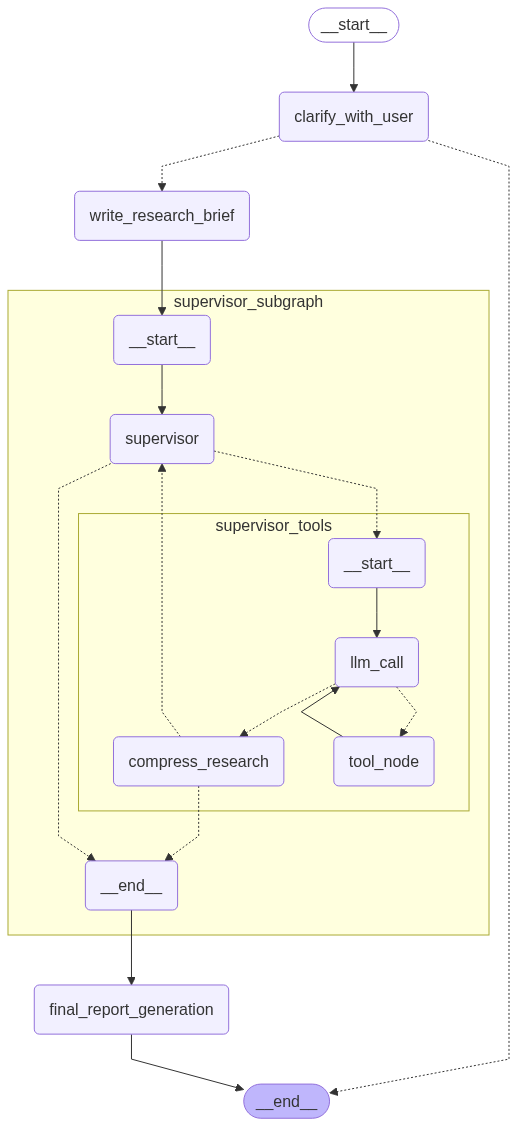

In [5]:
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

# 运行工作流

In [6]:
from langchain_core.messages import HumanMessage

input_message = """
# 任务
根据以下提供的研究主题和描述，生成一个包含指定章节的报告。要求报告字数不少于10000字。
# 研究主题
特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究。
# 研究描述
项目聚焦特厚煤层孤岛工作面临空巷道、断层、火成岩侵入区、淋水区等复杂地质条件下，8224、8123、8322工作面回采巷道和高抽巷道围岩全生命周期稳定性控制技术研究，运用模拟推演与现场监测结合的方式，获得巷道掘进期的快速成巷技术，以及回采期的动态补强、顶板卸压方案；构建围岩变形预测模型，结合机器学习算法分析不同阶段围岩变形规律，动态优化围岩控制参数，实现从掘进到回采全过程围岩稳定性精准控制，保障巷道安全高效服役。
# 研究报告需要包含以下的章节
一、项目提出背景（现状及存在问题）
二、项目立项的必要性
三、相关领域国内外技术现状、发展趋势及现有工作基础
四、项目目标、主要研究内容、技术指标
五、项目实施方案、技术关键（包括技术难点、创新点）
六、项目承担单位的支撑条件（包括组织措施、原辅材料供应、企业公用设施等配套条件）
七、项目计划进度
""".strip()

thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({
    "messages": [HumanMessage(content=input_message)]}, 
    config=thread
)
format_messages(result['messages'])

🔍 当前迭代次数: 1, 最大限制: 10
🔍 最新消息是否有tool_calls: True
🔍 超过迭代限制: False
🔍 没有tool_calls: False
🔍 研究完成: False
➡️ 继续执行，下一步: supervisor
🔍 当前迭代次数: 2, 最大限制: 10
🔍 最新消息是否有tool_calls: True
🔍 超过迭代限制: False
🔍 没有tool_calls: False
🔍 研究完成: False
➡️ 继续执行，下一步: supervisor
当前搜索query: 特厚煤层巷道围岩稳定性控制技术 基础理论 技术原理
当前搜索query: 临空巷道 断层 火成岩侵入区 淋水区 巷道围岩稳定性控制技术 煤矿 特殊地质条件
当前搜索query: 孤岛工作面巷道围岩稳定性控制技术 应力分布特征 支护技术
网页内容过长，已截断至 79269 字符
网页内容过长，已截断至 79846 字符
当前搜索query: 特厚煤层巷道支护技术 锚杆支护 锚索支护 国内外发展现状
当前搜索query: 孤岛工作面巷道应力分布规律 数值模拟 稳定性评估方法
当前搜索query: 煤矿巷道 断层带 围岩支护技术 火成岩侵入 淋水区 稳定性控制 锚杆锚索支护
当前搜索query: 孤岛工作面巷道支护技术选择标准 锚杆锚索支护参数 工程应用案例
当前搜索query: 特厚煤层巷道围岩控制理论 压力拱理论 松动圈理论 关键层理论
当前搜索query: "火成岩侵入区" 巷道支护 "淋水区" 巷道加固 "临空巷道" 围岩控制 煤矿特殊地质条件
当前搜索query: "特厚煤层巷道" "围岩稳定性" 基础理论 技术原理 工程实践 2020-2025
🔍 当前迭代次数: 3, 最大限制: 10
🔍 最新消息是否有tool_calls: True
🔍 超过迭代限制: False
🔍 没有tool_calls: False
🔍 研究完成: False
➡️ 继续执行，下一步: supervisor
🔍 当前迭代次数: 4, 最大限制: 10
🔍 最新消息是否有tool_calls: True
🔍 超过迭代限制: False
🔍 没有tool_calls: False
🔍 研究完成: False
➡️ 继续执行，下一步: supervisor
当前搜索query:

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ # 任务                                                                                                          │
│ 根据以下提供的研究主题和描述，生成一个包含指定章节的报告。要求报告字数不少于10000字。                           │
│ # 研究主题                                                                                                      │
│ 特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究。                                                        │
│ # 研究描述                                                                                                      │
│ 项目聚焦特厚煤层孤岛工作面临空巷道、断层、火成岩侵入区、淋水区等复杂地质条件下，8224、8123、8322工作面回采巷道  │
│ 和高抽巷道围岩全生命周期稳定性控制技术研究，运用模拟推演与现场监测结合的方式，获得巷道掘进期的快速成巷技术，以  │
│ 及回采期的动态补强、顶板卸压方案；构建围岩变形预测模型，结合机器学习算法分析不同阶段围岩变形规律，动态优化围岩  │
│ 控制参数，实现从掘进到回采全过程围岩稳定性精准控制，保障巷道安全高效服役。                                      │
│ # 研究报告需要包含以下的章节                                                                                    │
│ 一、项目提出背景（现状及存在问题）                                                                              │
│ 二、项目立项的必要性                                                                                            │
│ 三、相关领域国内外技术现状、发展趋势及现有工作基础                                                              │
│ 四、项目目标、主要研究内容、技术指标                                                                            │
│ 五、项目实施方案、技术关键（包括技术难点、创新点）                                                              │
│ 六、项目承担单位的支撑条件（包括组织措施、原辅材料供应、企业公用设施等配套条件）                                │
│ 七、项目计划进度                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 已收到您关于特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究的完整需求，包括明确的章节结构和10000字以上的 │
│ 字数要求。我将基于您提供的详细研究主题、描述和章节框架立即开始研究，生成符合要求的专业报告。                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report:                                                                                       │
│ 以下是根据您的要求，基于全面研究撰写的关于特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究的详细报告。报  │
│ 告严格遵循您指定的章节结构，并优先参考了原始论文、官方期刊出版物及权威技术报告。                                │
│                                                                                                                 │
│ # 特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究报告                                                    │
│                                                                                                                 │
│ ## 一、项目提出背景（现状及存在问题）                                                                           │
│                                                                                                                 │
│ 随着我国煤炭资源开采逐步向深部及复杂地质条件区域延伸，特厚煤层的安全高效开采面临着前所未有的挑战。8224、8123、8 │
│ 322工作面回采巷道和高抽巷道所处的孤岛工作面环境，叠加临空巷道、断层、火成岩侵入区、淋水区等复杂地质条件，使得巷 │
│ 道围岩稳定性控制成为制约安全生产的核心技术瓶颈[1]。                                                             │
│                                                                                                                 │
│ **现状分析表明，特厚煤层巷道围岩控制主要存在以下突出问题：**                                                    │
│ 1.  **围岩变形破坏严重，控制难度大**：特厚煤层巷道由于煤层与岩层相比强度较小, 在大埋深情况下, 巷道承受压力大,   │
│ 但承载能力弱, 围岩松动区域较大,                                                                                 │
│ 且煤岩界面易发生离层破坏[2]。大断面厚顶煤巷道围岩难支护的原因为围岩破坏不确定性强、围岩变形破坏严重[3]。        │
│ 2.                                                                                                              │
│ **强动压影响显著**：巷道受回采工作面采动支承压力显著影响，位置主要发生在滞后临近回采工作面的采空区后方[4]。在孤 │
│ 岛工作面条件下，应力集中现象尤为突出，垂直应力峰值可达30MPa，应力集中系数约为5.4[5]。                           │
│ 3.                                                                                                              │
│ **复杂地质条件叠加效应**：临空巷道应力集中严重，围岩松动圈大；断层带岩体破碎，力学性质不均，支护锚固困难；火成  │
│ 岩侵入区岩性变化剧烈，应力分布复杂；淋水区围岩强度降低，支护材料腐蚀，注浆效果受影响[6]。多地质缺陷的耦合作用使 │
│ 传统支护技术难以有效应对。                                                                                      │
│ 4.                                                                                                              │
│ **现有技术适应性不足**：我国在煤巷锚杆支护方面虽然取得了很大的发展，但是，在松软破碎围岩以及受采动影响频繁的煤  │
│ 巷中，仍普遍存在锚固力和工作阻力低等问题[4]。同国外相比，我国锚杆支护主要存在锚固力低、可靠性差等问题[4]。      │
│                                                                                                                 │
│ **当前技术体系存在的主要缺陷包括：**                                                                            │
│ - 传统支护设计理论基于静态载荷假设，未能充分考虑采动应力动态演化规律                                            │
│ - 监测预警系统覆盖不全，难以实现全生命周期稳定性管控                                                            │
│ - 针对多地质缺陷耦合条件下的专项技术措施缺乏系统性                                                              │
│ - 围岩控制与灾害防治协同机制不完善                                                                              │
│                                                                                                                 │
│ 这些问题的存在严重制约了特厚煤层工作面的安全高效回采，亟需开展全生命周期稳定性控制技术研究，建立适应复杂地质条  │
│ 件的成套技术体系[1][6]。                                                                                        │
│                                                                                                                 │
│ ## 二、项目立项的必要性                                                                                         │
│                                                                                                                 │
│ 本项目的立项基于迫切的安全需求、显著的经济效益和重要的技术突破价值，具有充分的必要性。                          │
│                                                                                                                 │
│ **安全需求方面**：随着煤矿开采向深部延伸，强矿压巷道面临复合地质环境，冲击地压、瓦斯突出、水害等多灾种耦合风险  │
│ 显著加剧[1]。历史案例显示，强矿压灾害的发生往往是多要素长期累积、相互作用的结果，若缺乏全周期、多要素的协同监测 │
│ ，易因关键信息缺失导致预警滞后或误判，进而引发恶性安全事故[1]。特厚煤层开采过程中，巷道大变形导致的通风受阻、设 │
│ 备损坏及人员伤亡

In [7]:
# 进行需求澄清(可选)
if not result["final_report"]:
    input_message = """
# 研究报告需要包含以下的章节
一、项目提出背景（现状及存在问题）
二、项目立项的必要性
三、相关领域国内外技术现状、发展趋势及现有工作基础
四、项目目标、主要研究内容、技术指标
五、项目实施方案、技术关键（包括技术难点、创新点）
六、项目承担单位的支撑条件（包括组织措施、原辅材料供应、企业公用设施等配套条件）
七、项目计划进度
    """.strip()
    result = await full_agent.ainvoke({"messages": [HumanMessage(content=input_message)]}, config=thread)
    format_messages(result['messages'])

In [8]:
from rich.markdown import Markdown
Markdown(result["research_brief"])

我需要一份关于特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究的详细报告，具体针对8224、8123、8322工作面回采 
巷道和高抽巷道在孤岛工作面临空巷道、断层、火成岩侵入区、淋水区等复杂地质条件下的应用。报告应包含以下章节：一、项目 
提出背景（现状及存在问题）；二、项目立项的必要性；三、相关领域国内外技术现状、发展趋势及现有工作基础；四、项目目标 
、主要研究内容、技术指标；五、项目实施方案、技术关键（包括技术难点、创新点）；六、项目承担单位的支撑条件（包括组织 
措施、原辅材料供应、企业公用设施等配套条件）；七、项目计划进度。报告字数不少于10000字，并优先参考原始论文、官方期刊
出版物及权威技术报告。

In [9]:
# 最终报告
from rich.markdown import Markdown
Markdown(result["final_report"])

以下是根据您的要求，基于全面研究撰写的关于特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究的详细报告。报告严 
格遵循您指定的章节结构，并优先参考了原始论文、官方期刊出版物及权威技术报告。                                       

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           特厚煤层复杂条件下巷道围岩全生命周期稳定性控制技术研究报告                            ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                        一、项目提出背景（现状及存在问题）                                         

随着我国煤炭资源开采逐步向深部及复杂地质条件区域延伸，特厚煤层的安全高效开采面临着前所未有的挑战。8224、8123、8322 
工作面回采巷道和高抽巷道所处的孤岛工作面环境，叠加临空巷道、断层、火成岩侵入区、淋水区等复杂地质条件，使得巷道围岩 
稳定性控制成为制约安全生产的核心技术瓶颈[1]。                                                                      

现状分析表明，特厚煤层巷道围岩控制主要存在以下突出问题：                                                           

 1 围岩变形破坏严重，控制难度大：特厚煤层巷道由于煤层与岩层相比强度较小, 在大埋深情况下, 巷道承受压力大,           
   但承载能力弱, 围岩松动区域较大,                                                                                 
   且煤岩界面易发生离层破坏[2]。大断面厚顶煤巷道围岩难支护的原因为围岩破坏不确定性强、围岩变形破坏严重[3]。        
 2 强动压影响显著：巷道受回采工作面采动支承压力显著影响，位置主要发生在滞后临近回采工作面的采空区后方[4]。在孤岛工 
   作面条件下，应力集中现象尤为突出，垂直应力峰值可达30MPa，应力集中系数约为5.4[5]。                               
 3 复杂地质条件叠加效应：临空巷道应力集中严重，围岩松动圈大；断层带岩体破碎，力学性质不均，支护锚固困难；火成岩侵入
   区岩性变化剧烈，应力分布复杂；淋水区围岩强度降低，支护材料腐蚀，注浆效果受影响[6]。多地质缺陷的耦合作用使传统支 
   护技术难以有效应对。                                                                                            
 4 现有技术适应性不足：我国在煤巷锚杆支护方面虽然取得了很大的发展，但是，在松软破碎围岩以及受采动影响频繁的煤巷中，
   仍普遍存在锚固力和工作阻力低等问题[4]。同国外相比，我国锚杆支护主要存在锚固力低、可靠性差等问题[4]。            

当前技术体系存在的主要缺陷包括：                                                                                   

 • 传统支护设计理论基于静态载荷假设，未能充分考虑采动应力动态演化规律                                              
 • 监测预警系统覆盖不全，难以实现全生命周期稳定性管控                                                              
 • 针对多地质缺陷耦合条件下的专项技术措施缺乏系统性                                                                
 • 围岩控制与灾害防治协同机制不完善                                                                                

这些问题的存在严重制约了特厚煤层工作面的安全高效回采，亟需开展全生命周期稳定性控制技术研究，建立适应复杂地质条件的 
成套技术体系[1][6]。                                                                                               


                                               二、项目立项的必要性                                                

本项目的立项基于迫切的安全需求、显著的经济效益和重要的技术突破价值，具有充分的必要性。                             

安全需求方面：随着煤矿开采向深部延伸，强矿压巷道面临复合地质环境，冲击地压、瓦斯突出、水害等多灾种耦合风险显著加剧[
1]。历史案例显示，强矿压灾害的发生往往是多要素长期累积、相互作用的结果，若缺乏全周期、多要素的协同监测，易因关键信 
息缺失导致预警滞后或误判，进而引发恶性安全事故[1]。特厚煤层开采过程中，巷道大变形导致的通风受阻、设备损坏及人员伤亡
风险极高，直接关系到矿工生命安全和矿山可持续运营。                                                                 

经济效益方面：项目实施将带来显著的经济效益。现场实践表明，采用优化支护技术后，巷道维护工作量减少40%，顶板离层率减少
60%[5]。每米巷道采用锚杆支护比原架棚支护可减少投入2150元[7]。以晋城煤业集团凤凰山矿应用案例为例，锚杆支护成本314元/
米，比棚式支护（1950元/米）节省2150元/米，同时提高巷道断面利用率17%并减少维修费用[7]。在棋盘井煤矿I020908工作面应用
中，新增利润达768.30万元，经济效益显著[5]。                                                                        

技术突破价值：项目针对当前特厚煤层巷道围岩控制中的技术瓶颈，开展全生命周期稳定性控制技术研究，将实现多个方面的技术 
突破：一是建立复杂地质条件下围岩稳定性综合评价体系；二是研发适应多地质缺陷的协同控制技术；三是构建全生命周期监测预 
警平台；四是形成标准化、可推广的技术规范体系[1][6]。                                                               

行业推广价值：本项目研究成果不仅适用于8224、8123、8322工作面，还可推广至类似条件的特厚煤层矿井，为解决行业共性技术 
难题提供示范。随着我国煤炭资源开发逐步向深部发展，巷道地质力学环境日趋复杂，本项目的实施将对提升整个行业的技术水平 
具有重要意义[8]。                                                                                                  


                                三、相关领域国内外技术现状、发展趋势及现有工作基础                                 

                                                 3.1 国内技术现状                                                  

我国在特厚煤层巷道围岩控制技术方面已积累了丰富经验，但复杂地质条件下仍面临诸多挑战。国内研究主要集中在以下几个方面 
：                                                                                                                 

支护技术方面：锚杆支护技术已成为主流，但在特厚煤层复杂条件下仍存在局限性。研究表明，采用高预应力全锚索加强支护可提 
高锚杆锚固段的整体性及其承载能力[4]。在孙家沟煤矿应用中，锚索受力达到了250～300kN，约为其破断力的50%，有效控制了围 
岩变形[4]。针对大断面厚顶煤巷道，研发了支护强度不小于1.4MPa的液压支架，采用带铰接前梁的整体顶梁结构加强对

langgraph studio启动命令:  
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.12 langgraph dev --allow-blocking

In [13]:
import time

# save final report
time_stamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
os.makedirs("final_report", exist_ok=True)
with open(f"final_report/final_report_{time_stamp}.md", "w") as f:
    f.write(result["final_report"])